IsolationForest

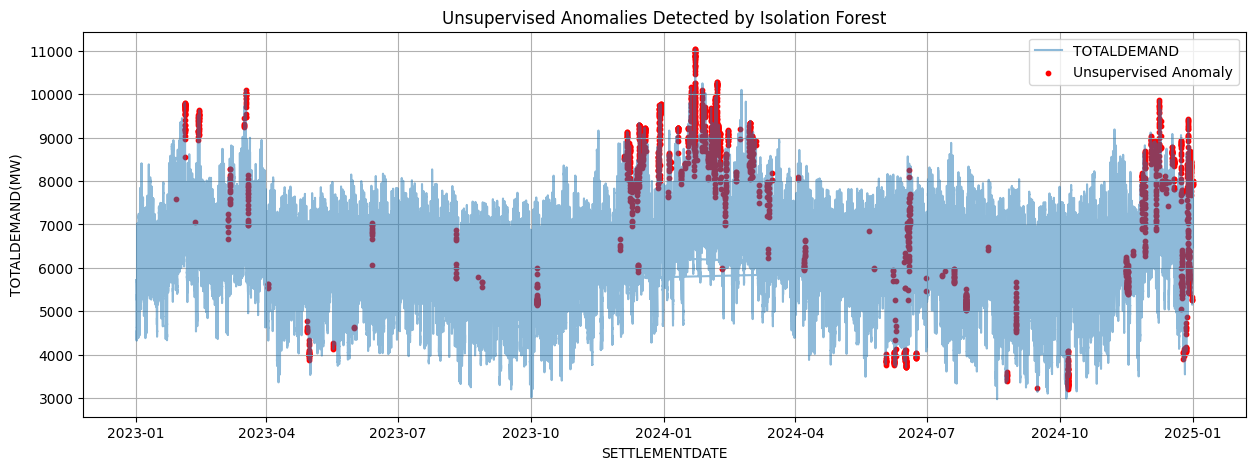

🔁 Overlap with labelled anomalies: 13 out of 485 labelled anomalies


In [3]:
# 📦 Imports
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 🔹 1. Load and Prepare Data
# ================================
df = pd.read_csv("combined_dispatch_price_demand_2023_2024.csv", parse_dates=["SETTLEMENTDATE"])

# Select features (no RRP!)
features = [
    "TOTALDEMAND",
    "AVAILABLEGENERATION",
    "INTERCONNECTORFLOWS",
    "INTERVENTION"
]
df = df.dropna(subset=features)
X = df[features]

# ================================
# 🔹 2. Scale the Data
# ================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ================================
# 🔹 3. Fit Isolation Forest
# ================================
model = IsolationForest(
    n_estimators=100,
    contamination=0.01,  # 1% of data flagged as anomaly
    random_state=42
)
df["unsupervised_anomaly_score"] = model.fit_predict(X_scaled)
df["unsupervised_anomaly"] = df["unsupervised_anomaly_score"] == -1

# ================================
# 📈 4. Visualise Anomalies on Time Series
# ================================
plt.figure(figsize=(15, 5))
plt.plot(df["SETTLEMENTDATE"], df["TOTALDEMAND"], label="TOTALDEMAND", alpha=0.5)
plt.scatter(
    df[df["unsupervised_anomaly"]]["SETTLEMENTDATE"],
    df[df["unsupervised_anomaly"]]["TOTALDEMAND"],
    color="red", s=10, label="Unsupervised Anomaly"
)
plt.legend()
plt.title("Unsupervised Anomalies Detected by Isolation Forest")
plt.ylabel("TOTALDEMAND(MW)")
plt.xlabel("SETTLEMENTDATE")
plt.grid()
plt.show()

# ================================
# 🔍 5. Compare with is_anomaly (if exists)
# ================================
if "is_anomaly" in df.columns:
    overlap = ((df["unsupervised_anomaly"]) & (df["is_anomaly"] == True)).sum()
    print(f"🔁 Overlap with labelled anomalies: {overlap} out of {df['is_anomaly'].sum()} labelled anomalies")


LOF (LocalOutlierFactor)

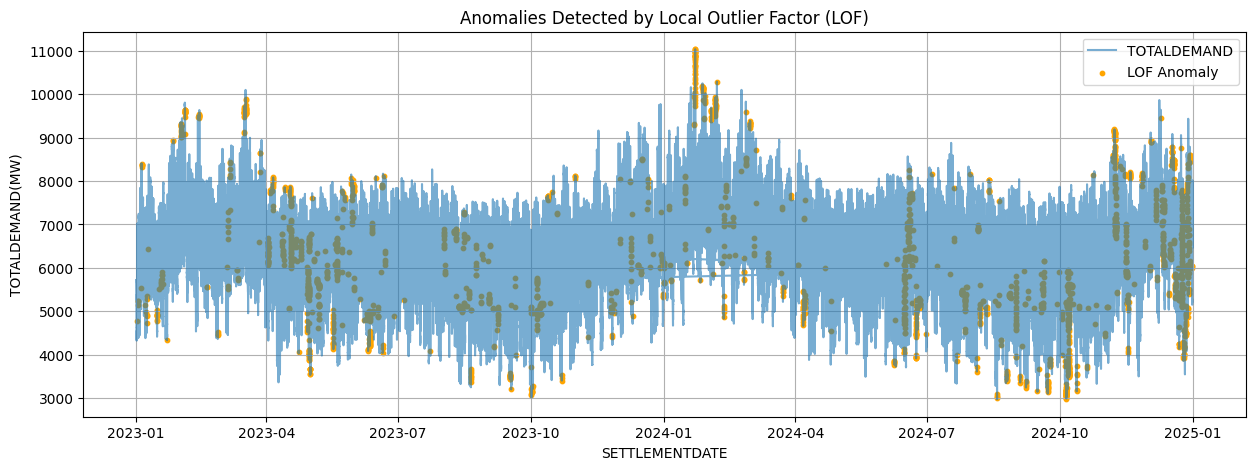

🔁 Overlap with labelled anomalies: 95 out of 485


In [4]:
# 📦 Imports
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ================================
# 🔹 1. Load and Prepare Data
# ================================
df = pd.read_csv("combined_dispatch_price_demand_2023_2024.csv", parse_dates=["SETTLEMENTDATE"])

features = [
    "TOTALDEMAND",
    "AVAILABLEGENERATION",
    "INTERCONNECTORFLOWS",
    "INTERVENTION"
]
df = df.dropna(subset=features)
X = df[features]

# ================================
# 🔹 2. Scale the Data
# ================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ================================
# 🔹 3. Fit Local Outlier Factor
# ================================
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
y_pred = lof.fit_predict(X_scaled)

# -1 = anomaly, 1 = normal
df["lof_anomaly"] = y_pred == -1

# ================================
# 📈 4. Visualise Anomalies in Demand
# ================================
plt.figure(figsize=(15, 5))
plt.plot(df["SETTLEMENTDATE"], df["TOTALDEMAND"], label="TOTALDEMAND", alpha=0.6)
plt.scatter(
    df[df["lof_anomaly"]]["SETTLEMENTDATE"],
    df[df["lof_anomaly"]]["TOTALDEMAND"],
    color="orange", label="LOF Anomaly", s=10
)
plt.title("Anomalies Detected by Local Outlier Factor (LOF)")
plt.xlabel("SETTLEMENTDATE")
plt.ylabel("TOTALDEMAND(MW)")
plt.grid()
plt.legend()
plt.show()

# ================================
# 🔍 5. Compare to manual labels (optional)
# ================================
if "is_anomaly" in df.columns:
    overlap_lof = ((df["lof_anomaly"]) & (df["is_anomaly"] == True)).sum()
    print(f"🔁 Overlap with labelled anomalies: {overlap_lof} out of {df['is_anomaly'].sum()}")


Goal:

Create a visual story showing whether anomalies tend to occur during high-demand periods.

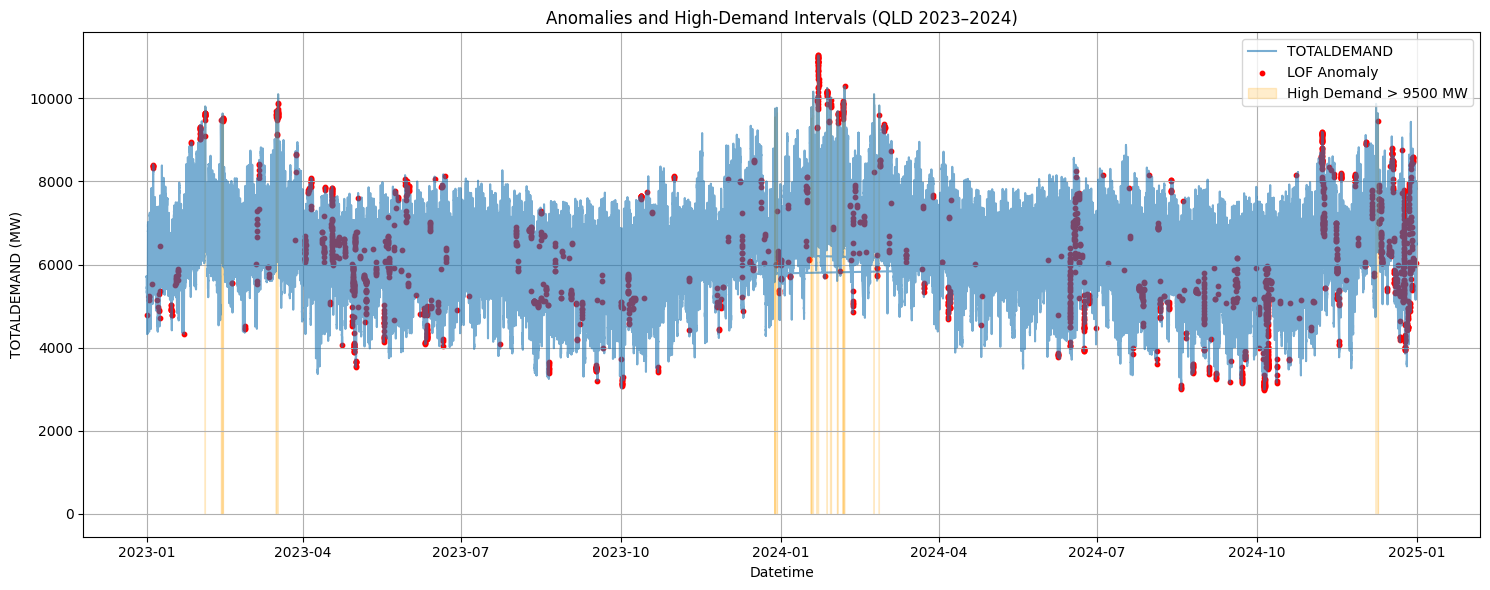

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Define high demand threshold (adjust as needed)
high_demand_threshold = 9500  # MW

# Create a flag for high demand intervals
df["is_high_demand"] = df["TOTALDEMAND"] > high_demand_threshold

# Plot
plt.figure(figsize=(15, 6))

# Plot total demand time series
plt.plot(df["SETTLEMENTDATE"], df["TOTALDEMAND"], label="TOTALDEMAND", alpha=0.6)

# Plot anomalies detected by LOF
plt.scatter(
    df[df["lof_anomaly"]]["SETTLEMENTDATE"],
    df[df["lof_anomaly"]]["TOTALDEMAND"],
    color="red", s=10, label="LOF Anomaly"
)

# Highlight high demand intervals with a light orange background
plt.fill_between(
    df["SETTLEMENTDATE"],
    df["TOTALDEMAND"],
    where=df["is_high_demand"],
    color="orange",
    alpha=0.2,
    label=f"High Demand > {high_demand_threshold} MW"
)

# Labels and legend
plt.title("Anomalies and High-Demand Intervals (QLD 2023–2024)")
plt.xlabel("Datetime")
plt.ylabel("TOTALDEMAND (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Not all price or system anomalies are driven by extreme demand.